DS 8014 Graph Mining
Assignment 1

Gorkem Sarp;
Richa Sharma

In [1]:
## In addition to sources provided, some of the code was taken from our labs, ie: 
## https://github.com/ftheberge/GraphMiningNotebooks

In [2]:
## required packages 
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
import random
from geopy.distance import geodesic
from scipy.stats import pearsonr

# Question 2

In [3]:
D = pd.read_csv("gridkit_north_america-highvoltage-links.csv")
tuples = [tuple(x) for x in zip(D["v_id_1"],D["v_id_2"])]
gr = ig.Graph.TupleList(tuples,directed = False )
X = pd.read_csv("gridkit_north_america-highvoltage-vertices.csv")
gr.simplify()

In [4]:
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

In [5]:
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []

S.append(['Grid Graph'] + baseStats(gr))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

,0
graph,Grid Graph
nodes,16167
edges,20242
$d_{min}$,1
$d_{mean}$,2.504113
$d_{median}$,2.0
$d_{quant_{99}}$,7.0
$d_{max}$,22
diameter,138
components,34


# Question 3

# (a)

In [6]:
##Below was taken from our lab

## read the GitHub edge list as tuples and build undirected graph

D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)


## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_ml.vcount()

9739

In [7]:
#Regular adjacency matrix took too long to calculate
adj_matrix = gh_ml.get_adjacency()
#np_adj_matrix = np.array(adj_matrix.data)
#np_adj_matrix.shape
#np_adj_matrix_power5 = np.linalg.matrix_power(np_adj_matrix,5)

sparse_adj_matrix = gh_ml.get_adjacency_sparse()
sparse_adj_matrix_power5 = sparse_adj_matrix**5 #using ** since it's a sparse matrix, instead of power
print("number of walks of length 5 is: ", sparse_adj_matrix_power5.sum())

number of walks of length 5 is:  36175204754.0


# (b)

In [8]:
# The following code was taken from
# https://www.geeksforgeeks.org/cycles-of-length-n-in-an-undirected-and-connected-graph/


V = gh_ml.vcount() # Number of vertices
 
def DFS(graph, mark, n, vert, start, count): #depth first search, n is number of cycles
 
    mark[vert] = True # mark the vertex vert as visited
  
    # we use (n-1) length paths because nth edge will close the cycle 
    # if there is (n-1) length path 
    if n == 0:
 
        # mark vert to make it usable again
        mark[vert] = False
  
        # If vertex vert can end with vertex start, add to count
        if graph[vert][start] == 1:
            count = count + 1
            return count
        else:
            return count
  
    # All possible paths of length (n-1)
    for i in range(V):
        if mark[i] == False and graph[vert][i] == 1:
 
            # depth first search with n-1
            count = DFS(graph, mark, n-1, i, start, count)
  
    # mark vert to make it usable again
    mark[vert] = False
    return count
  

def cycle_count(graph, n):
 
    
    mark = [False] * V # marking all vertices as unvisited 
  
    # using v-n+1 vertices to search for cycle
    count = 0
    for i in range(V-(n-1)):
        count = DFS(graph, mark, n-1, i, i, count)
  
        # ith vertex is marked so that it won't be visited again 
        mark[i] = True
     
    return int(count/2)

In [9]:
adj_matrix_array = adj_matrix.data
print("number of cycles of length 4 is ",cycle_count(adj_matrix_array,4))

number of cycles of length 4 is  151228



# Question 4

# (a)

In [10]:
A = pd.read_csv("connections.csv")

In [11]:
A.head()
#A.shape

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [12]:
#v1_set=A["orig_airport"].unique()

In [13]:
tuples = [tuple(x) for x in zip(A["orig_airport"],A["dest_airport"]) ]
ga = ig.Graph.TupleList(tuples, directed = True)
ga.es["Weights"] = A["total_passengers"]

In [14]:
In = ga.degree(mode="in")
Out = ga.degree(mode="out")
vertex_lst = ga.vs["name"]
total = [i + o for i, o in zip(In, Out)]
total_deg = sorted(set(total))
#print(len(total_deg))
deg_dist = [(d/ga.vcount()) for d in total_deg ]
#print(deg_dist)
cummulative_frq =[]
val=0
for deg in deg_dist:
    val+=deg
    cummulative_frq.append(val)
#print(In_degree, cummulative_frq)

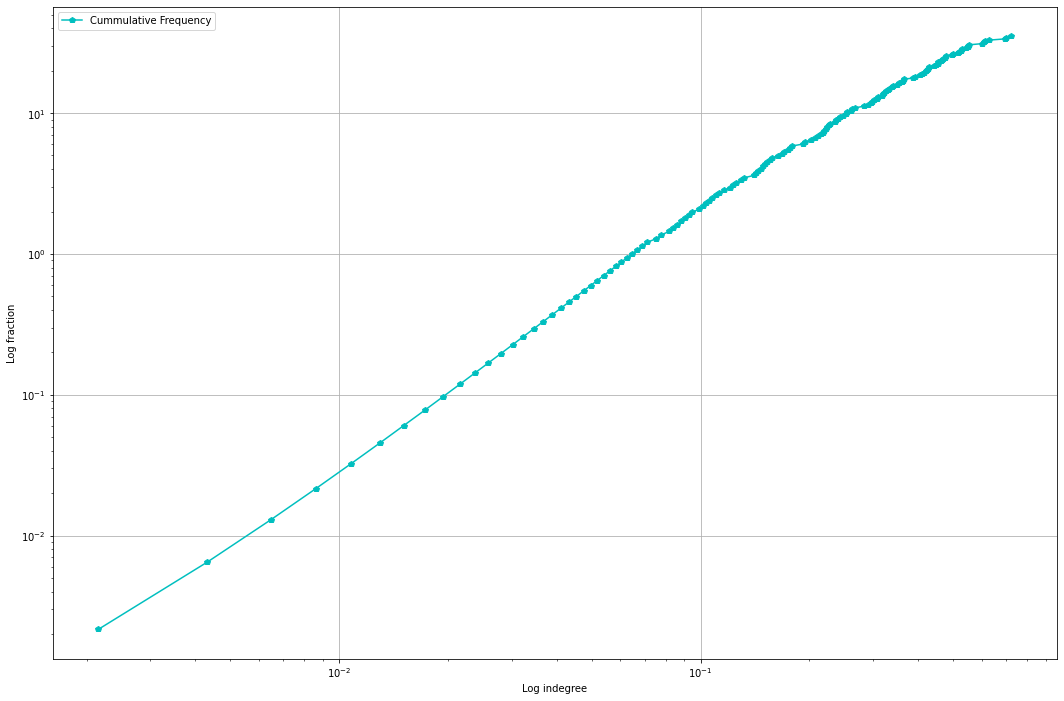

In [15]:
plt.figure(figsize=(18, 12)) 
plt.grid(True)
plt.loglog(deg_dist, cummulative_frq, 'cp-') 
plt.xlabel('Log indegree')
plt.ylabel('Log fraction')
plt.legend(["Cummulative Frequency"],loc='upper left')
#plt.legend(loc='best')
plt.show()

In [16]:
## Reference 1:https://www.reading.ac.uk/AcaDepts/sp/PPLATO/imp/interactive%20mathematics/loglog2.pdf
## Reference 2:https://stackoverflow.com/questions/53958700/plotting-the-degree-distribution-of-a-graph-using-nx-degree-histogram

# (b)

In [17]:
#Que: Find the busiest airport. In other words, find the node with the maximum total degree (degin(v) + degout(v)).
# Calculating the degrees
In = ga.degree(mode="in")
Out = ga.degree(mode="out")
vertex_lst = ga.vs["name"]
total = [i + o for i, o in zip(In, Out)]

In [18]:
## Creating a dataframe of the degrees of Vertices
df= pd.DataFrame({"Vertex":vertex_lst, "In_degree": In, "Out_degree": Out, "Total_degree":total })
df

,Vertex,In_degree,Out_degree,Total_degree
0,SFO,88,102,190
1,LAX,102,130,232
2,MCO,101,120,221
3,ATL,163,173,336
4,JFK,77,93,170
...,...,...,...,...
459,MOP,1,0,1
460,DET,0,1,1
461,WVL,1,0,1
462,AID,1,0,1


In [19]:
busiest_airport = df.loc[df["Total_degree"].idxmax()].values[0]
deg=df.loc[df["Total_degree"].idxmax()].values[3]

print("Busiest Airport is {} with total degree of {}".format(busiest_airport,deg))

Busiest Airport is ATL with total degree of 336


# (c)

In [20]:
# Que: Number of strongly connected components
ele = len(ig._igraph.GraphBase.clusters(ga,mode="strong"))
print("Number of elements in clusters:",ele)

Number of elements in clusters: 464


In [21]:
lst=list(ga.clusters(mode='strong'))
print("List of all clusters:", lst)

List of all clusters: [[463], [460], [461], [454], [453], [451], [447], [442], [428], [418], [417], [416], [411], [405], [404], [403], [400], [396], [393], [386], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 1

In [22]:
cl = len(ga.clusters(mode="strong"))
print("Number of strongly connected clusters are: ",cl)

Number of strongly connected clusters are:  40


# (d)

In [23]:
## que:Find the subgraph induced by all airports from California.
##Find the number of isolated nodes in this subgraph.

## List the airport code of California
df = pd.read_csv('airports_loc.csv')
airports = list(df.loc[df['state']=='CA', "airport"])
print("List of airports in California :",airports)

# Build the subgraph 
ga_sub = ga.subgraph([v for v in ga.vs() if v['name'] in airports])

# Find the nodes with degree zero
isolated_nodes = sum([x==0 for x in ga_sub.degree()])
print("\nTotal isolated nodes in the subgraph are:",isolated_nodes)

List of airports in California : ['ACV', 'APC', 'BFL', 'CEC', 'CIC', 'FAT', 'IPL', 'LAX', 'MCC', 'MCE', 'MHR', 'MOD', 'NKX', 'NZY', 'OAK', 'OXR', 'RDD', 'RIV', 'SAN', 'SBA', 'SBP', 'SCK', 'SDM', 'SEE', 'SFO', 'SJC', 'SMF', 'SNA', 'STS', 'TKF', 'VIS']

Total isolated nodes in the subgraph are: 9


# Question 5

In [24]:
##Below was taken from our lab:

## read edge list to build undirected graph
gr_europe_highvoltage = ig.Graph.Read_Ncol('gridkit_europe-highvoltage.edges', directed=False)
gr_europe_highvoltage = gr_europe_highvoltage.simplify()

## read vertices with attributes
att_file = pd.read_csv('gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr_europe_highvoltage.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
att_file['Rank'] = att_file['v_id'].map(sorterIndex)
att_file.sort_values(['Rank'], ascending=[True],inplace=True)
att_file.dropna(inplace=True)


gr_europe_highvoltage.vs['longitude'] = list(att_file['lon'])
gr_europe_highvoltage.vs['latitude'] = list(att_file['lat'])
gr_europe_highvoltage.vs['type'] = list(att_file['typ'])
gr_europe_highvoltage.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr_europe_highvoltage.vs()] 
gr_europe_highvoltage.vs['size'] = 3
gr_europe_highvoltage.es['color'] = 'grey'
gr_europe_highvoltage.vs['color'] = 'black'

,Vertex 1,Location 1,Vertex 2,Location 2,Graph distance,Geographic distance
0,7439,"(45.8935828516244, 13.3444884436002)",9983,"(47.6697307092155, 10.3697993206213)",43.0,300.939321
1,8731,"(54.2609517122291, 39.0113806580798)",694,"(46.149554873388, 12.7392833172324)",47.0,2064.951505
2,12634,"(41.4438312291202, 14.0689730850973)",231,"(51.3535238692661, 4.26745385390053)",49.0,1332.201219
3,7163,"(48.019067345377, 7.5726115473122)",10568,"(44.7680776005864, 2.68282962142817)",16.0,521.367084
4,12875,"(48.0849771137593, 12.637077568136)",8885,"(41.033448490818, 14.3927074512619)",56.0,795.845041
...,...,...,...,...,...,...
95,4479,"(45.3850468163497, 11.281998426783)",3842,"(50.7893879666169, 10.9996629635499)",42.0,601.285875
96,464,"(50.9170399455599, -1.03987491424455)",10253,"(49.3493026798737, 7.04751815777639)",24.0,603.588739
97,4993,"(40.5796812190775, 15.2460381188031)",1162,"(52.034620164836, 8.85635693636294)",79.0,1363.805155
98,8728,"(52.2092119688994, 23.9355612481925)",7090,"(43.3353217972121, -4.07788758972144)",83.0,2300.619022


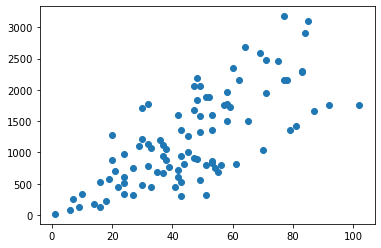

In [25]:
v1_list = []
v2_list = []
loc1_list = []
loc2_list = []
distance_list = []
shortest_path_dist_list = []


for x in range(100):

    #using random number generator, we get vertex indices 
    randon_number1 = random.randint(0,gr_europe_highvoltage.vcount())
    v1_list.append(randon_number1)
    randon_number2 = random.randint(0,gr_europe_highvoltage.vcount())
    v2_list.append(randon_number2)

    
    #we got latitude and longitude to find geographic distance using geodesic
    loc1 = (gr_europe_highvoltage.vs[randon_number1]['latitude'], gr_europe_highvoltage.vs[randon_number1]['longitude'])
    loc1_list.append(loc1)
    loc2 = (gr_europe_highvoltage.vs[randon_number2]['latitude'], gr_europe_highvoltage.vs[randon_number2]['longitude'])
    loc2_list.append(loc2)
    distance = geodesic(loc1, loc2).km
    distance_list.append(distance)

    #we found shortest path to get graph distance
    shortest_path_dist = gr_europe_highvoltage.shortest_paths(source=gr_europe_highvoltage.vs[randon_number1], 
                                                              target=gr_europe_highvoltage.vs[randon_number2])[0][0]
    shortest_path_dist_list.append(shortest_path_dist)


result_dic = {"Vertex 1": v1_list, "Location 1": loc1_list, "Vertex 2": v2_list, "Location 2": loc2_list, 
              "Graph distance": shortest_path_dist_list, "Geographic distance": distance_list}


plt.scatter(shortest_path_dist_list, distance_list)

result_df = pd.DataFrame(result_dic )
result_df

In [26]:
result_distances_df = pd.DataFrame({"Graph distance": shortest_path_dist_list, "Geographic distance": distance_list})

print(result_distances_df.corr('pearson'))

print("There seems to be a moderate to strong correlation between two distances, ie: pearson correlation of greater than 0.6")

                     Graph distance  Geographic distance
Graph distance             1.000000             0.739026
Geographic distance        0.739026             1.000000
There seems to be a moderate to strong correlation between two distances, ie: pearson correlation of greater than 0.6
